# Univariate LSTM - n assets (in-sample) prediction
Some helpful resources

https://github.com/alexavierc/LSTM-Stock-Prices/blob/master/LSTM%20Single%20Company.ipynb

[Multi stock prediction w single nn](https://www.kaggle.com/humamfauzi/multiple-stock-prediction-using-single-nn),
[LSTM math](https://medium.com/deep-math-machine-learning-ai/chapter-10-1-deepnlp-lstm-long-short-term-memory-networks-with-math-21477f8e4235)
## 1. Import Libraries

In [1]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

#LSTM RNN
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

#Check for stationarity
from sklearn.metrics import mean_squared_error

plt.style.use('seaborn-darkgrid')
%matplotlib inline


Using TensorFlow backend.


#### Get and visualize data 

In [2]:
def get_data(asset_name):
    return pd.read_csv('Asset_Dataset/'+asset_name+'_10y.csv', usecols=['Date','Adj Close'], parse_dates=True, index_col='Date' ).astype('float32').dropna()

def get_vol(asset_name):
    return pd.read_csv('Asset_Dataset/'+asset_name+'_10y.csv', usecols=['Date','Volume'], parse_dates=True, index_col='Date' ).astype('float32').dropna()


Text(0.5, 0, 'Time')

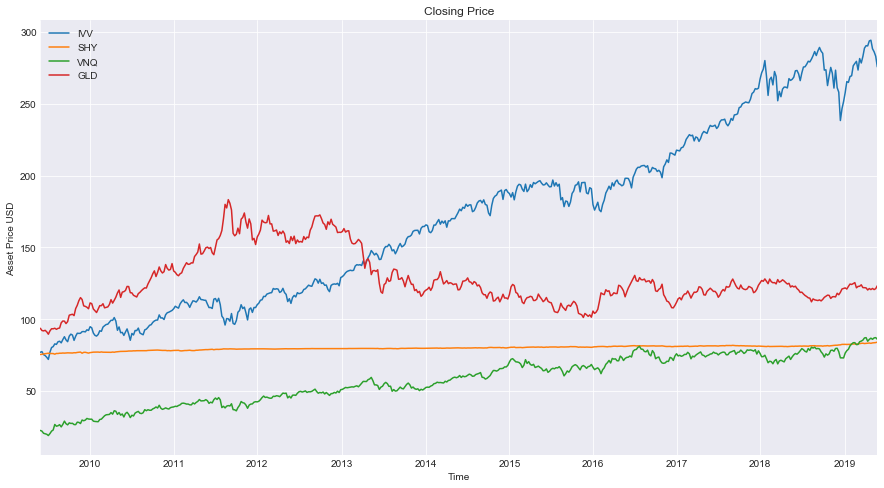

In [3]:
#assets
data_SHY = get_data('SHY')
data_IVV = get_data('IVV')
data_GLD = get_data('GLD')
data_VNQ = get_data('VNQ')
#SP500
data_GSPC = get_data('GSPC')

#Concatenate, and turn into dataframe
asset_closing = pd.concat([data_IVV,data_SHY,data_VNQ,data_GLD], axis=1)
asset_closing.columns=['IVV','SHY','VNQ','GLD']

asset_closing.plot(figsize=(15,8))
plt.title('Closing Price')
plt.ylabel('Asset Price USD')
plt.xlabel('Time')

#### Helper functions
Root of mean squared error (helper fn)

In [4]:
def rmse_return(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))


### Univariate LSTM - Single Asset
Train-test split: Train (Jun 2009 - May 2015), Test (Jun 2015 - Jun 2019):
* 6 years training, 4 years testing
* Use closing price to predict closing price


* Goal: Predict the closing price of n forward_week, using input of m past weeks (look_back).

In [5]:
look_back = 26 # number of weeks as input
forward_week = 4 # predict n weeks ahead
num_periods = 8 # Last k weeks for the test set

In [6]:
array = data_GLD.values.reshape(data_GLD.shape[0],1)


In [7]:
mm = MinMaxScaler()

In [8]:
array = mm.fit_transform(array)

In [9]:
division = len(array) - num_periods*forward_week

array_test = array[division-look_back:]
array_train = array[:division]

In [10]:
#Get the data and splits in input X and output Y, by spliting in n past days as input X 
#and m coming days as Y.
# convert an array of values into a dataset matrix

def processData(data, look_back, forward_week,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_week +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_week)])
    return np.array(X),np.array(Y)

Test set will be the last k (num_periods) periods we want test the model. In each period, the model will predict the next n forward_week. The remaning data will be used for Train/Validation.

In [11]:
X_test,y_test = processData(array_test,look_back,forward_week,forward_week)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,look_back,forward_week)
y = np.array([list(a.ravel()) for a in y])

In [15]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.40, random_state=30)

In [16]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

(276, 26, 1)
(185, 26, 1)
(8, 26, 1)
(276, 4)
(185, 4)
(8, 4)


#### Training LSTM

In [17]:
NUM_NEURONS_FirstLayer = 64
NUM_NEURONS_SecondLayer = 32
EPOCHS = 200

#Build the model
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dropout(0.1))
model.add(Dense(forward_week))
model.compile(loss='mse', optimizer='adam')

history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=25, verbose=2)

Train on 276 samples, validate on 185 samples
Epoch 1/200
 - 5s - loss: 0.1444 - val_loss: 0.0363
Epoch 2/200
 - 1s - loss: 0.0250 - val_loss: 0.0135
Epoch 3/200
 - 1s - loss: 0.0156 - val_loss: 0.0101
Epoch 4/200
 - 1s - loss: 0.0123 - val_loss: 0.0071
Epoch 5/200
 - 1s - loss: 0.0113 - val_loss: 0.0063
Epoch 6/200
 - 1s - loss: 0.0094 - val_loss: 0.0081
Epoch 7/200
 - 1s - loss: 0.0104 - val_loss: 0.0059
Epoch 8/200
 - 1s - loss: 0.0098 - val_loss: 0.0057
Epoch 9/200
 - 1s - loss: 0.0098 - val_loss: 0.0061
Epoch 10/200
 - 1s - loss: 0.0108 - val_loss: 0.0059
Epoch 11/200
 - 1s - loss: 0.0088 - val_loss: 0.0056
Epoch 12/200
 - 1s - loss: 0.0100 - val_loss: 0.0062
Epoch 13/200
 - 1s - loss: 0.0093 - val_loss: 0.0052
Epoch 14/200
 - 1s - loss: 0.0078 - val_loss: 0.0050
Epoch 15/200
 - 1s - loss: 0.0078 - val_loss: 0.0052
Epoch 16/200
 - 1s - loss: 0.0082 - val_loss: 0.0048
Epoch 17/200
 - 1s - loss: 0.0086 - val_loss: 0.0051
Epoch 18/200
 - 1s - loss: 0.0081 - val_loss: 0.0050
Epoch 19/

Epoch 154/200
 - 1s - loss: 0.0035 - val_loss: 0.0032
Epoch 155/200
 - 1s - loss: 0.0036 - val_loss: 0.0032
Epoch 156/200
 - 1s - loss: 0.0039 - val_loss: 0.0033
Epoch 157/200
 - 1s - loss: 0.0036 - val_loss: 0.0031
Epoch 158/200
 - 1s - loss: 0.0035 - val_loss: 0.0029
Epoch 159/200
 - 1s - loss: 0.0033 - val_loss: 0.0028
Epoch 160/200
 - 1s - loss: 0.0032 - val_loss: 0.0028
Epoch 161/200
 - 1s - loss: 0.0033 - val_loss: 0.0029
Epoch 162/200
 - 1s - loss: 0.0034 - val_loss: 0.0029
Epoch 163/200
 - 1s - loss: 0.0037 - val_loss: 0.0029
Epoch 164/200
 - 1s - loss: 0.0033 - val_loss: 0.0029
Epoch 165/200
 - 1s - loss: 0.0036 - val_loss: 0.0028
Epoch 166/200
 - 1s - loss: 0.0033 - val_loss: 0.0028
Epoch 167/200
 - 1s - loss: 0.0034 - val_loss: 0.0029
Epoch 168/200
 - 1s - loss: 0.0035 - val_loss: 0.0030
Epoch 169/200
 - 1s - loss: 0.0033 - val_loss: 0.0029
Epoch 170/200
 - 1s - loss: 0.0030 - val_loss: 0.0030
Epoch 171/200
 - 1s - loss: 0.0036 - val_loss: 0.0032
Epoch 172/200
 - 1s - loss: 

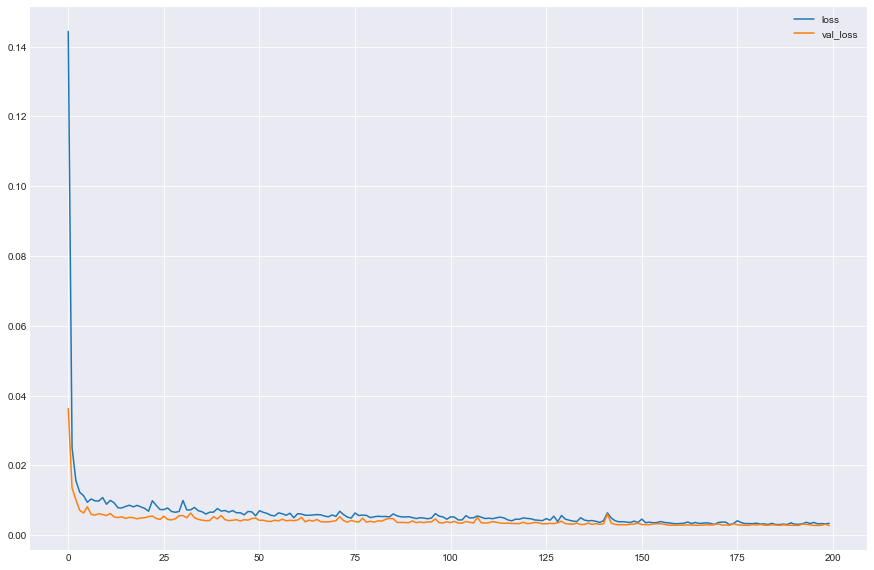

In [18]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

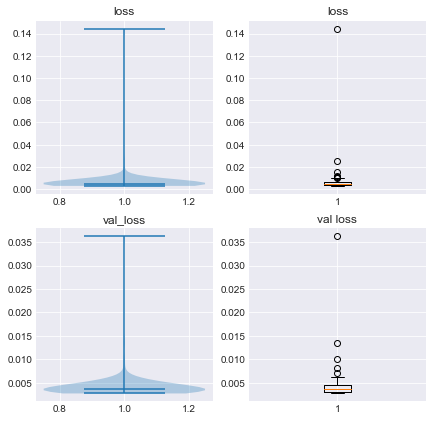

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))

# plot violin plot
axes[0,0].violinplot(history.history['loss'],
                   showmeans=False,
                   showmedians=True)
axes[0,0].set_title('loss')

# plot box plot
axes[0,1].boxplot(history.history['loss'])
axes[0,1].set_title('loss')

# plot violin plot
axes[1,0].violinplot(history.history['val_loss'],
                   showmeans=False,
                   showmedians=True)
axes[1,0].set_title('val_loss')

# plot box plot
axes[1,1].boxplot(history.history['val_loss'])
axes[1,1].set_title('val loss')
plt.show()

### Predict full dataset

In [20]:
division = len(array) - num_periods*forward_week

leftover = division%forward_week+1

array_test = array[division-look_back:]
array_train = array[leftover:division]

In [21]:
Xtrain,ytrain = processData(array_train,look_back,forward_week,forward_week)
Xtest,ytest = processData(array_test,look_back,forward_week,forward_week)

In [22]:
Xtrain = model.predict(Xtrain)
Xtrain = Xtrain.ravel()

Xtest = model.predict(Xtest)
Xtest = Xtest.ravel()

In [23]:
y = np.concatenate((ytrain, ytest), axis=0)


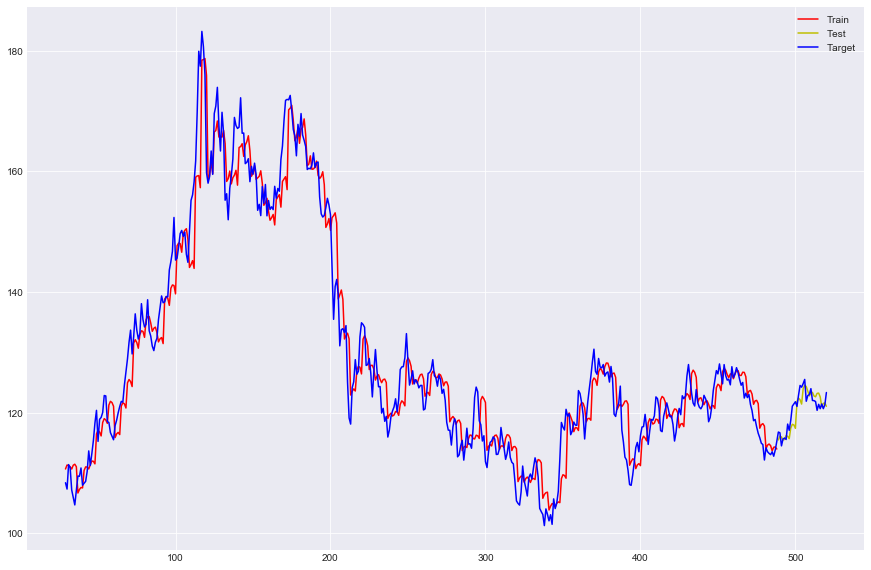

In [24]:

plt.figure(figsize = (15,10))

# Data in Train/Validation
plt.plot([x for x in range(look_back+leftover, len(Xtrain)+look_back+leftover)], mm.inverse_transform(Xtrain.reshape(-1,1)), color='r', label='Train')
# Data in Test
plt.plot([x for x in range(look_back +leftover+ len(Xtrain), len(Xtrain)+len(Xtest)+look_back+leftover)], mm.inverse_transform(Xtest.reshape(-1,1)), color='y', label='Test')

#Data used
plt.plot([x for x in range(look_back+leftover, look_back+leftover+len(Xtrain)+len(Xtest))], mm.inverse_transform(y.reshape(-1,1)), color='b', label='Target')

#Initial data. It should overlap the data used
#plt.plot(scl.inverse_transform(array), color='b', label='Esperado')

plt.legend(loc='best')
plt.show()

In [ ]:
fig = plt.figure(figsize=[15, 10])
plt.suptitle('Univariate LSTM Predictions')

plt.subplot(221)
pred_IVV.Pred_Univar.plot(c='orange')
pred_IVV['True'].plot(c='blue')
plt.legend(['Prediction','True'])
plt.title('IVV True vs Univariate Prediction')
plt.ylabel('USD')
plt.xlabel('Date')

plt.subplot(222)
plt.title('Percent Change by Day, difference between True and Predicted')
plt.ylabel('Difference in Percent')
plt.xlabel('Date')
change_pct_IVV.Univar.plot(c='orange')
change_pct_IVV.Tru.plot(c= 'blue')
plt.legend(['Univariate Prediction','True']);
plt.show()

In [ ]:
print('SKLearn Regression metrics: \n')
print('Mean Squared Error: ' + str(sklm.mean_squared_error(df.y, df.yhat)) + '\n')
print('Explained Variance Score: ' + str(sklm.explained_variance_score(df.y, df.yhat)) + '\n')
print('Max Error: ' + str(sklm.max_error(df.y, df.yhat)) + '\n')
print('Mean Absolute Error: ' + str(sklm.mean_absolute_error(df.y, df.yhat)) + '\n')
print('Mean Squared Log Error: ' + str(sklm.mean_squared_log_error(df.y, df.yhat)) + '\n')
print('Median Absolute Error : ' + str(sklm.median_absolute_error(df.y, df.yhat)) + '\n')
print('R2 Score: ' + str(sklm.r2_score(df.y, df.yhat)) + '\n')